### ANN - Hopfield Networks

* Edward Carrillo eccarrilloe@unal.edu.co
* Eliana Garzón egarzonv@unal.edu.co
* Diego Velásquez arvelasqueza@unal.edu.co
* Sneyder Gantiva esgantivar@unal.edu.co

[Shared Link](https://colab.research.google.com/drive/1PQ2lmlSjrWwl07zjT-JzGykkYGIcLWFU?usp=sharing)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

Auxiliar methods

In [ ]:
def flattening(data):
  n_data, dim_x, dim_y = tuple(data.shape)
  x = data.reshape((n_data, dim_x * dim_y)) / 255 
  x = tf.math.sign((x * 2) - 1)
  return x.numpy()

In [ ]:
def noisify(pattern, numb_flipped=30):
  noisy_pattern = pattern.copy()
  for idx, row in enumerate(noisy_pattern):
    choices = np.random.choice(range(len(row)), numb_flipped)
    noisy_pattern[idx,choices] = -noisy_pattern[idx,choices]
  return noisy_pattern

In [ ]:
def noisify_flat(pattern, numb_flipped=30):
  dim_x, dim_y = tuple(pattern.shape)
  noisy_pattern = pattern.reshape(dim_x * dim_y) / 255
  noisy_pattern = (tf.math.sign((noisy_pattern * 2) - 1)).numpy()
  choices = np.random.choice(range(noisy_pattern.shape[0]), numb_flipped)
  noisy_pattern[choices] = -noisy_pattern[choices]
  return noisy_pattern.reshape(dim_x, dim_y)

### Hopfield Network

<img src="https://ml-esgantivar.s3.amazonaws.com/hopfield.png" alt="net" width="500"/>

Train Matrix
$$W = \frac{1}{n} \sum_{k}^{n}p_k p_k^{T} - I$$

Recall a pattern
$$p^{(t + 1)} = sgn(Wp^{(t)})$$ 

Energy
$$E = -\frac{1}{2} \sum_{i,j} w_{i j}s_is_j + \sum_{i}\theta_is_i$$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Energy_landscape.png/1000px-Energy_landscape.png" alt="energy" width="600"/>

Energy Landscape of a Hopfield Network, highlighting the current state of the network (up the hill), an attractor state to which it will eventually converge, a minimum energy level and a basin of attraction shaded in green. Note how the update of the Hopfield Network is always going down in Energy, taken from [here](https://en.wikipedia.org/wiki/Hopfield_network). 

In [ ]:
class HopfieldNetwork(object):
  def __init__(self):
    self.verbose = False
    self.early_stop = True
    self.sync = True
  
  def train_weights(self, train_data):
    num_data, self.num_neuron = train_data.shape        
    W = np.zeros((self.num_neuron, self.num_neuron))
    for p in train_data:
      W = W + np.outer(p,p)
    diagW = np.diag(np.diag(W))
    W = W - diagW
    print("Weight matrix BEFORE normalization = {}".format(W))
    W /= num_data
    print("Weight matrix AFTER normalization = {}".format(W))
    self.W = W

  def predict(self, data, num_iter=20, threshold=0, early_stop=True, verbose=False, sync=True):
    self.verbose = verbose
    self.early_stop = early_stop
    self.sync = sync
    print("Start to predict...")
    self.num_iter = num_iter
    self.threshold = threshold
    copied_data = np.copy(data)
    predicted = []
    for i in tqdm(range(len(data))):
        predicted.append(self._run(copied_data[i]))
    self.verbose = False
    self.early_stop = True
    self.sync = True
    return predicted

  def _run(self, init_s):
    
    p = init_s
    e = self.energy(p)
    title = f'i: {0}, energy: {e}'
    self.show(p, title)
    sgn = np.vectorize(lambda x: 1 if x >= 0 else -1)
    if self.sync:
      """
        Synchronous update: All units are updated at the same time.
      """
      for i in range(self.num_iter):
        p = sgn(np.dot(self.W, p) - self.threshold)
        e_new = self.energy(p)
        title = f'i: {i + 1}, energy: {e_new}'
        self.show(p, title)
        if e == e_new and self.early_stop:
          print(f'stop at: {i}')
          return p
        e = e_new
    else:
      """
        Asynchronous update: Only one unit is updated at a time. This unit will be picked at random.
      """
      for i in range(self.num_iter + 1):
        unit = np.random.randint(low=0, high=p.shape[0] - 1)
        unit_weights = self.W[unit,:]
        net_input = np.dot(unit_weights, p)
        p[unit] = 1 if net_input > self.threshold else -1
        e = self.energy(p)
        title = f'i: {i + 1}, energy: {e}'
        if i % 500 == 0:
          self.show(p, title)
    return p

  def energy(self, s):
    return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

  def show(self, p, title):
    if self.verbose:
      fig = plt.figure(figsize=(2, 2))
      plt.title(title)
      dim = int(np.sqrt(p.shape[0]))
      plt.imshow(p.reshape(dim, dim), cmap='gray',vmin=-1, vmax=1)
      plt.show()
    else:
      print(title)

### MNIST Example

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
data_train = np.concatenate((x_train[y_train == 0][0:1], x_train[y_train == 4][0:1]))
data_test = np.concatenate((x_test[y_test == 0][0:1], x_test[y_test == 4][0:1]))
data_test_noisy = np.array([noisify_flat(i, 50) for i in data_test])
data_train.shape, data_test.shape, data_test_noisy.shape

((2, 28, 28), (2, 28, 28), (2, 28, 28))

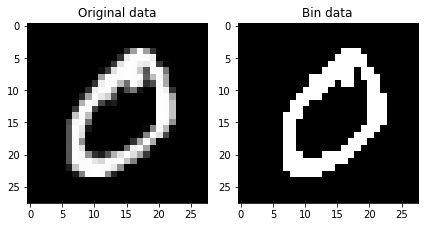

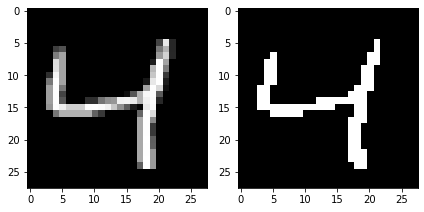

In [ ]:
for idx in range(data_train.shape[0]):
  fig, ax = plt.subplots(1,2)
  if idx == 0:
    ax[0].set_title("Original data")
    ax[1].set_title("Bin data")
  ax[0].imshow(data_train[idx], cmap='gray', vmin=0, vmax=255)
  ax[1].imshow(train_flat[idx].reshape((28,28)), cmap='gray', vmin=-1, vmax=1)
  fig.tight_layout() 

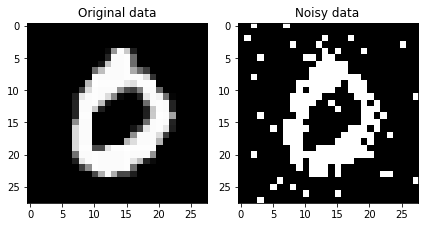

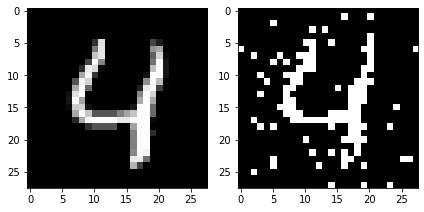

In [ ]:
for idx in range(data_test.shape[0]):
  fig, ax = plt.subplots(1,2)
  if idx == 0:
    ax[0].set_title("Original data")
    ax[1].set_title('Noisy data')
  ax[0].imshow(data_test[idx], cmap='gray', vmin=0, vmax=255)
  ax[1].imshow(data_test_noisy[idx], cmap='gray', vmin=-1, vmax=1)
  fig.tight_layout() 

In [ ]:
train_flat = flattening(data_train)
train_flat.shape

(2, 784)

In [ ]:
model = HopfieldNetwork()
model.train_weights(train_flat)

2 784
Weight matrix BEFORE normalization = [[0. 2. 2. ... 2. 2. 2.]
 [2. 0. 2. ... 2. 2. 2.]
 [2. 2. 0. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 0. 2. 2.]
 [2. 2. 2. ... 2. 0. 2.]
 [2. 2. 2. ... 2. 2. 0.]]
Weight matrix AFTER normalization = [[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]




  0%|          | 0/2 [00:00<?, ?it/s]

Start to predict...


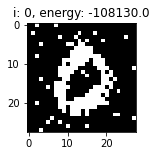

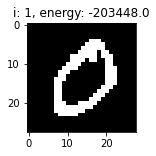

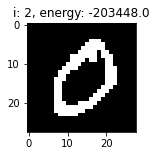



 50%|█████     | 1/2 [00:00<00:00,  1.47it/s]

stop at: 1


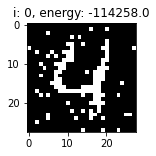

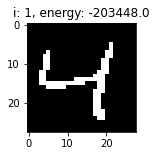

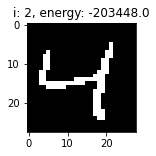



100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

stop at: 1


In [ ]:
predicted = model.predict(data_test_noisy.reshape(data_test_noisy.shape[0], 28 ** 2), threshold=0, num_iter=10, verbose=True, early_stop=True)



  0%|          | 0/2 [00:00<?, ?it/s]

Start to predict...


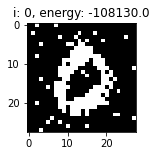

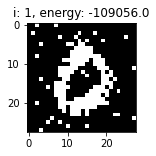

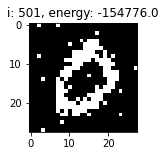

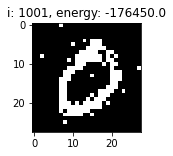

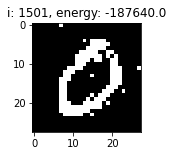

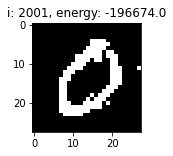

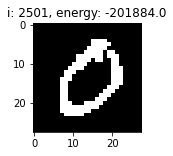

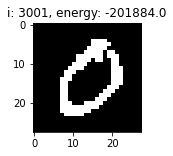

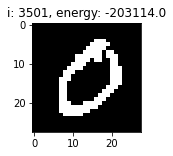

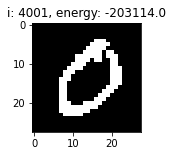

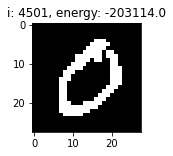

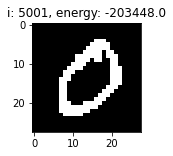



 50%|█████     | 1/2 [00:03<00:03,  3.48s/it]

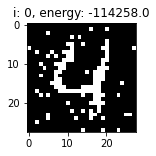

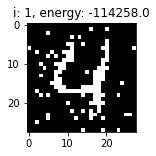

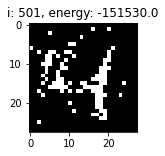

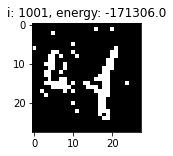

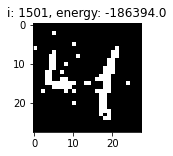

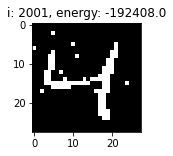

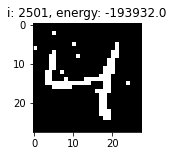

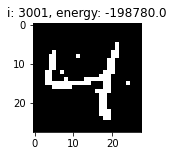

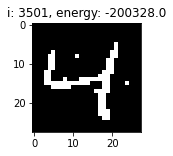

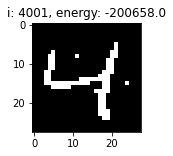

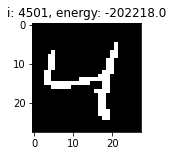

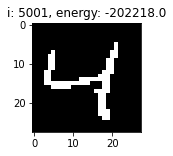



100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


In [ ]:
predicted = model.predict(data_test_noisy.reshape(data_test_noisy.shape[0], 28 ** 2), threshold=0, num_iter=5000, verbose=True, early_stop=True, sync=False)

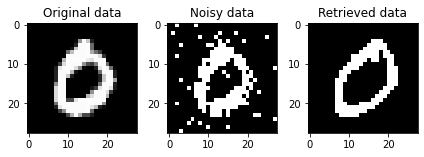

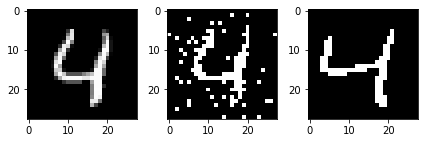

In [ ]:
for idx in range(data_test.shape[0]):
  fig, ax = plt.subplots(1,3)
  if idx == 0:
    ax[0].set_title("Original data")
    ax[1].set_title('Noisy data')
    ax[2].set_title('Retrieved data')
  ax[0].imshow(data_test[idx], cmap='gray', vmin=0, vmax=255)
  ax[1].imshow(data_test_noisy[idx], cmap='gray', vmin=-1, vmax=1)
  ax[2].imshow(predicted[idx].reshape(28, 28), cmap='gray', vmin=-1, vmax=1)
  fig.tight_layout() 

### Face Image Example

In [ ]:
def load_external_image(url, dim=90, threshold=65, show=False):
  import requests
  from PIL import Image
  from io import BytesIO
  response = requests.get(url)
  img_original = Image.open(BytesIO(response.content))
  img_original = img_original.resize((dim, dim))
  img = img_original.convert(mode="L")
  img_arr = np.array(img)
  img_arr = img_arr.reshape((dim ** 2,))
  sgn = np.vectorize(lambda x: 1 if x > threshold else -1)
  img_sgn = sgn(img_arr)
  if show:
    fig, ax = plt.subplots(1,3)
    ax[0].set_title("Original data")
    ax[1].set_title('Grayscale data')
    ax[2].set_title('Threshold data')
    ax[0].imshow(img_original)
    ax[1].imshow(img_arr.reshape(dim, dim), cmap='gray', vmin=0, vmax=255)
    ax[2].imshow(img_sgn.reshape(dim, dim), cmap='gray', vmin=-1, vmax=1)
    fig.tight_layout() 
  return img_arr, img_sgn

(8100,)

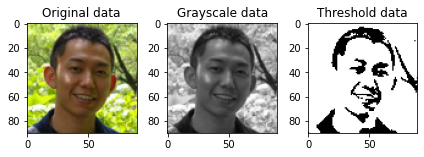

In [ ]:
img_train, img_sgn_train = load_external_image(url='https://raw.githubusercontent.com/yosukekatada/Hopfield_network/master/train_pics/yosuke.jpg', threshold=60, show=True)
img_sgn_train.shape

(8100,)

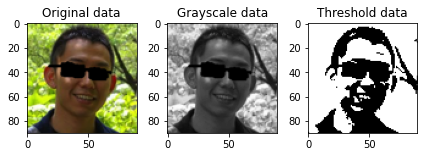

In [ ]:
img_test, img_sgn_test = load_external_image(url='https://raw.githubusercontent.com/yosukekatada/Hopfield_network/master/test_pics/yosuke_test.jpg', threshold=65, show=True)
img_sgn_test.shape

In [ ]:
model_face = HopfieldNetwork()
model_face.train_weights(np.array([img_sgn_train]))

1 8100
Weight matrix BEFORE normalization = [[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
Weight matrix AFTER normalization = [[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]




  0%|          | 0/1 [00:00<?, ?it/s]

Start to predict...


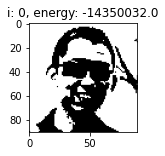

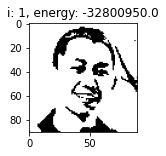

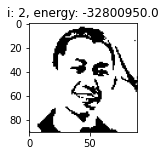



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

stop at: 1


In [ ]:
predicted = model_face.predict(np.array([img_sgn_test]), threshold=0, num_iter=10000, verbose=True, early_stop=True)



  0%|          | 0/1 [00:00<?, ?it/s]

Start to predict...


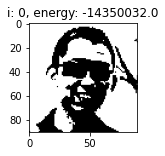

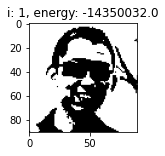

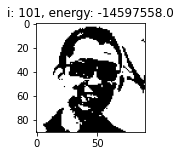

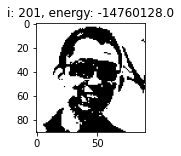

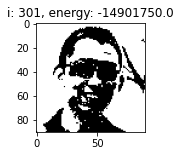

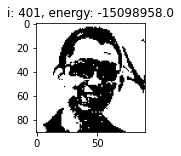

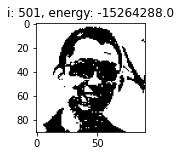

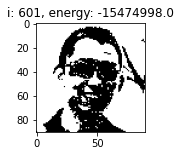

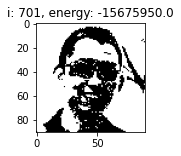

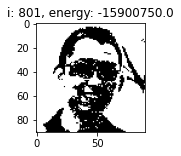

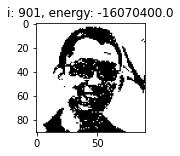

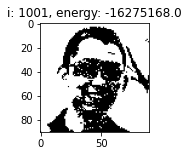

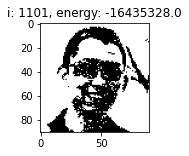

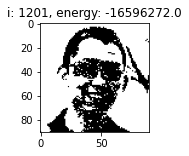

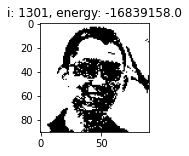

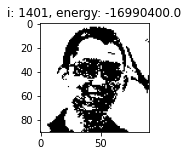

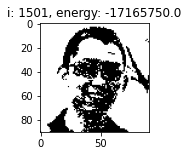

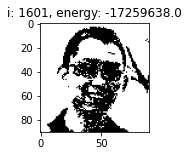

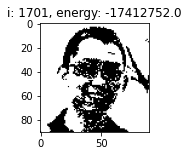

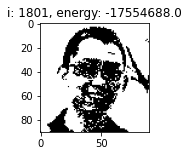

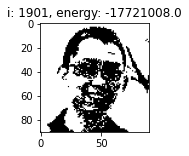

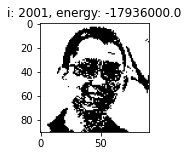

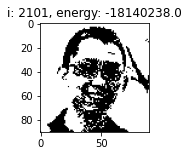

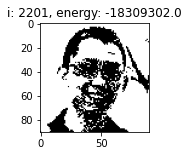

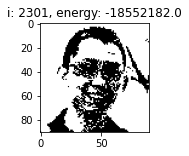

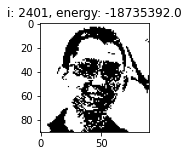

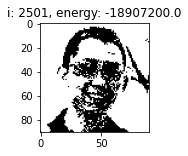

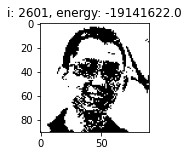

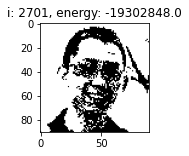

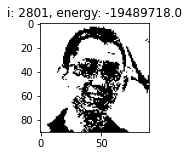

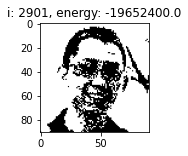

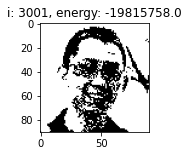

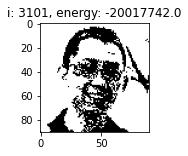

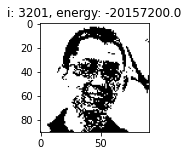

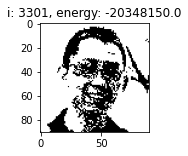

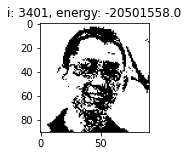

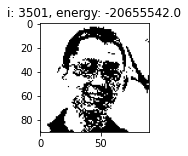

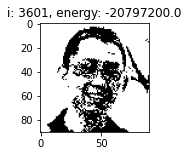

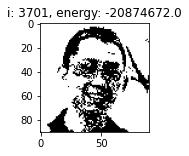

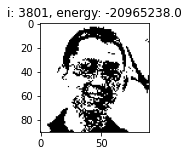

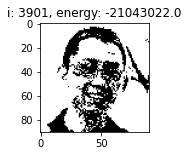

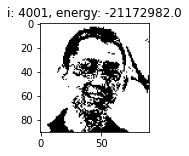

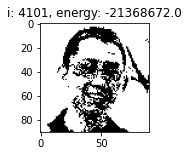

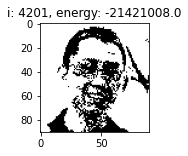

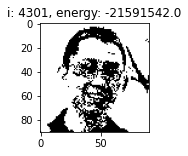

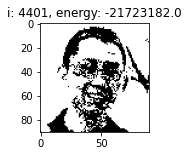

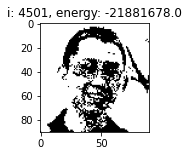

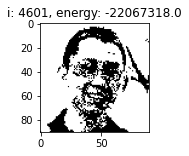

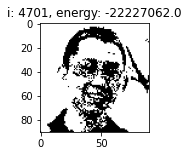

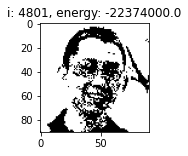

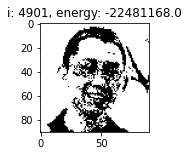

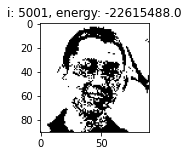

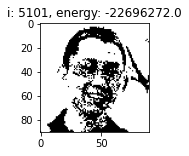

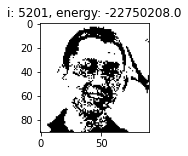

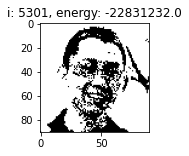

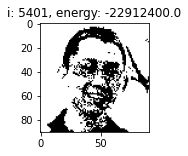

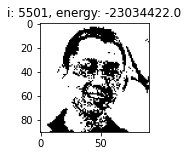

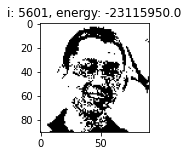

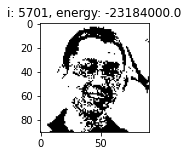

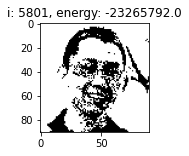

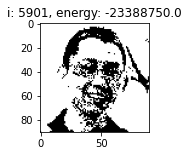

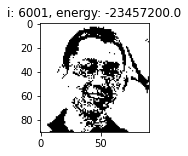

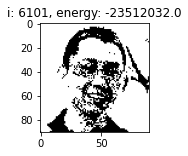

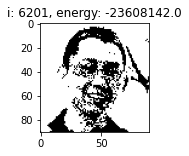

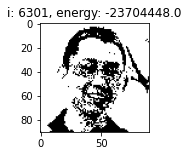

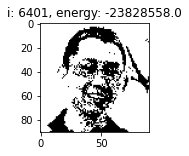

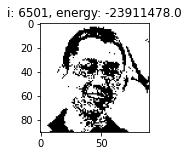

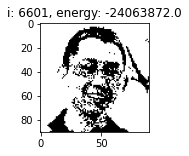

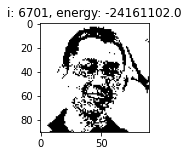

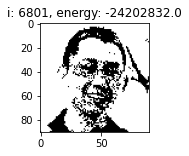

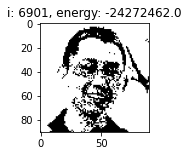

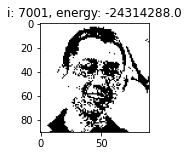

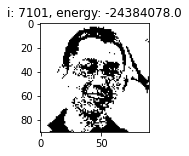

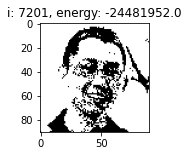

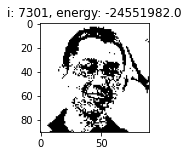

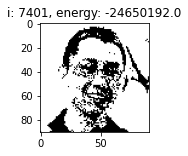

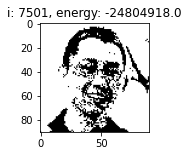

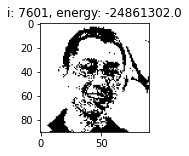

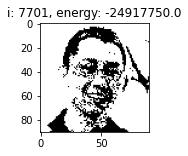

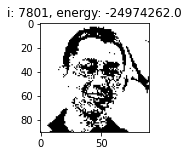

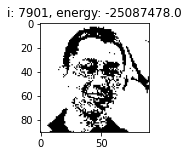

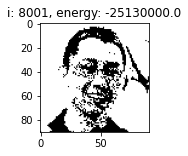

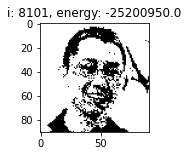

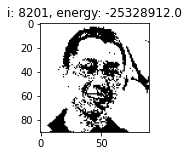

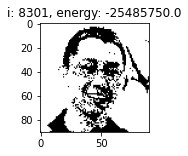

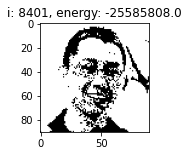

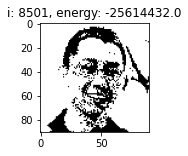

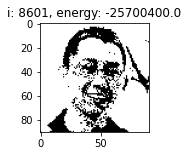

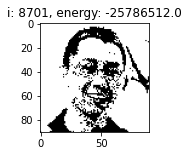

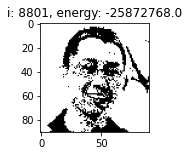

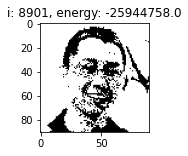

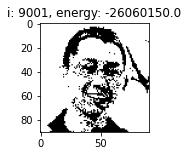

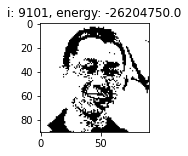

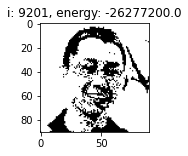

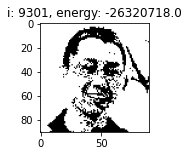

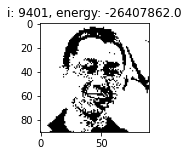

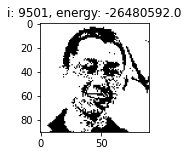

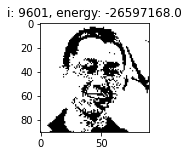

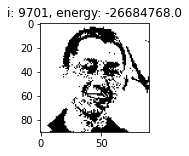

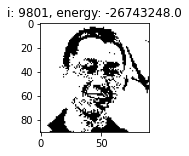

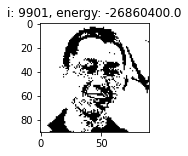

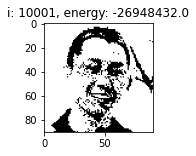



100%|██████████| 1/1 [09:29<00:00, 569.29s/it]


In [ ]:
predicted = model_face.predict(np.array([img_sgn_test]), threshold=0, num_iter=10000, verbose=True, early_stop=True, sync=False)